In [20]:
# 0. IMPORTANDO BIBLIOTECAS

# 0.1 manipulação e visualização
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# 0.2 machine learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit

# 0.3 label encoding
from sklearn.preprocessing import LabelEncoder

# 0.4 métricas de avaliação
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix, auc, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

# 0.5 outras
import time
import warnings
from scipy import interp
from pprint import pprint
from scipy.stats import norm
from collections import Counter
from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline

# 0.6 melhorar a visualização
%matplotlib inline
mpl.style.use('ggplot')
plt.style.use('fivethirtyeight')
sns.set(context='notebook', palette='dark', color_codes=True)

# 0.7 mesagens de warning
warnings.filterwarnings("ignore")


In [21]:
# 1. TRATANDO A BASE

# 1.1 IMPORTANDO A BASE
df = pd.read_csv('dataset_case.csv', header=0)

# 1.2 DEIXANDO AS COLUNAS EM MAIÚSCULO
cols = ['uf_oco', 'porte_veic', 'categoria_veic', 'configuracao_veic', 'tipo_veic', 'renovacao', 'cambio_veic','modelo_veic', 'marca_veic','combustivel_veic']
for col in cols:
     df[col]= df[col].str.upper()

# 1.3 DETERMINANDO A IDADE DO CARRO
df['idade'] = 2024 - df['ano_modelo_veic']
df['idade'].unique()

# 1.4 FORMATANDO DATAS
# 1.4.1 convert columns to datetime
df[['dt_aviso','dt_oco']] = df[['dt_aviso','dt_oco']].apply(pd.to_datetime)

# 1.4.2 calculate difference between dates
df['delta_oco_pri_cont'] = (df['dt_aviso'] - df['dt_oco']) / np.timedelta64(1, 'D')

# 1.4.3 view updated DataFrame
df['delta_oco_pri_cont'].unique()

df.head()


,OCORRENCIA,CONTRATO,dt_oco,dt_aviso,dt_inivig,ano_modelo_veic,bonus,renovacao,valor_is,cod_fipe,...,cep_oco,tipo_logradouro_oco,nome_logradouro_oco,numero_logradouro_oco,bairro_oco,cidade_oco,uf_oco,fraude,idade,delta_oco_pri_cont
0,114608,45598247,2023-06-28 03:33:12,2023-07-14 03:33:12,2023-07-16 14:15:49,2009,3,RENOVACAO CONGENERE,72326.0,211451,...,60060000,RUA,RODRIGUES JUNIOR,1260,CENTRO,FORTALEZA,CE,0.0,15,16.00
1,121978,85581395,2023-03-20 14:00:03,2023-03-22 06:48:03,2023-10-21 01:35:43,2009,7,RENOVACAO LIBERTY,196633.0,12092,...,90240510,AVENIDA,CEARA,555,S JOAO,PORTO ALEGRE,RS,0.0,15,1.70
2,194236,96773037,2023-04-02 23:54:48,2023-04-16 23:40:24,2023-07-03 11:54:06,2019,4,SEGURO NOVO,89281.0,53090,...,52050060,AVENIDA,DOUTOR MALAQUIAS,57,GRACAS,RECIFE,PE,0.0,5,13.99
3,100544,70013629,2023-05-14 00:48:47,2023-05-15 22:53:35,2023-10-23 08:55:55,2018,4,SEGURO NOVO,63641.0,231150,...,30170130,R,SAO PAULO,684,CENTRO,BELO HORIZONTE,MG,0.0,6,1.92
4,159643,29852209,2023-09-24 00:31:29,2023-09-24 18:02:41,2023-09-26 05:50:48,2004,0,RENOVACAO CONGENERE,106987.0,242071,...,15801150,RUA,BELO HORIZONTE,408a,CENTRO,CATANDUVA,SP,1.0,20,0.73


In [22]:

# 1.5 LIMPANDO A BASE
df.drop_duplicates()
df.dropna()
df = df.drop(['OCORRENCIA','CONTRATO', 'desc_oco', 'tipo_logradouro_oco', 'nome_logradouro_oco','bairro_oco', 'dt_oco', 'dt_aviso', 'dt_inivig', 'modelo_veic', 'cep_oco', 'cod_fipe', 'numero_logradouro_oco', 'categoria_veic', 'importacao_veic', 'ano_modelo_veic','cidade_oco'],axis=1)


# 1.6 TRATANDO CAMPO combustivel_veic
keys = ['ETA./GAS.', 'H�BRIDO', '�LCOOL/GA', 'HIBR�DO', 'ALCOOL/GA',  'ETA/GAS/GNV', 'FLEX']
for key in keys:
    df['combustivel_veic'] = df['combustivel_veic'].replace(key,"HIBRIDO")

keys = ['GAS.', 'GASOLINA ']
for key in keys:
    df['combustivel_veic'] = df['combustivel_veic'].replace(key,"GASOLINA")

keys = ['DIES.']
for key in keys:
    df['combustivel_veic'] = df['combustivel_veic'].replace(key,"DIESEL")

keys = ['ETA.', 'ALCOOL | ']
for key in keys:
    df['combustivel_veic'] = df['combustivel_veic'].replace(key,"ETANOL")

keys = ['EL�TRICO']
for key in keys:
    df['combustivel_veic'] = df['combustivel_veic'].replace(key,"ELETRICO")
df['combustivel_veic'].unique()

# 1.7 TRATANDO CAMPO porte
keys = ['GRD', 'GRA']
for key in keys:
    df['porte_veic'] = df['porte_veic'].replace(key,"GRANDE")

keys = ['MED', 'M�D', 'M�DIO']
for key in keys:
    df['porte_veic'] = df['porte_veic'].replace(key,"MEDIO")

keys = ['CO', 'COM', ' CO']
for key in keys:
    df['porte_veic'] = df['porte_veic'].replace(key,"COMPACTO")

keys = ['PEQ', 'PEQ ']
for key in keys:
    df['porte_veic'] = df['porte_veic'].replace(key,"PEQUENO")

keys = ['SEMI LEVE']
for key in keys:
    df['porte_veic'] = df['porte_veic'].replace(key,"SEM")

keys = ['SUBCOMPACTO']
for key in keys:
    df['porte_veic'] = df['porte_veic'].replace(key,"SUB")

# 1.8 TRATANDO CAMPO marca
keys = ['VOLKSWAGEN', 'VW  VOLKSWAGEN', 'VW', 'VW - VOLKSWAG']
for key in keys:
    df['marca_veic'] = df['marca_veic'].replace(key,"VOLKS")

keys = ["GM - CHEVROLE", "GM  CHEVROLET", "GM - CHEVROLET", 'GMC']
for key in keys:
    df['marca_veic'] = df['marca_veic'].replace(key,"CHEVROLET")

keys = ["CITRO�N"]
for key in keys:
    df['marca_veic'] = df['marca_veic'].replace(key,"CITROEN")

keys = ["MERCEDESBENZ"]
for key in keys:
    df['marca_veic'] = df['marca_veic'].replace(key,"MERCEDES-BENZ")

keys = ["KIA MOTORS"]
for key in keys:
    df['marca_veic'] = df['marca_veic'].replace(key,"KIA")

keys = ["SCANIA-VABIS", "SAAB-SCANIA"]
for key in keys:
    df['marca_veic'] = df['marca_veic'].replace(key,"SCANIA")

keys = ["CAOA CHERY"]
for key in keys:
    df['marca_veic'] = df['marca_veic'].replace(key,"CHERY")

keys = ["ROLLS ROYCE"]
for key in keys:
    df['marca_veic'] = df['marca_veic'].replace(key,"ROLLS-ROYCE")

keys = ["IVECO-FIAT"]
for key in keys:
    df['marca_veic'] = df['marca_veic'].replace(key,"FIAT")

keys = ["BABYBUGGY"]
for key in keys:
    df['marca_veic'] = df['marca_veic'].replace(key,"BUGGY")

keys = ["ROLLSROYCE"]
for key in keys:
    df['marca_veic'] = df['marca_veic'].replace(key,"ROLLS-ROYCE")

def replace_marca(string, keys):
    for key in keys:
        if key in string:
            string = key
            break
    return string
    
df['marca_veic'] = df['marca_veic'].apply(replace_marca, keys = ['MAHINDRA','EFFA','SSANG'])


# 1.9 TRATANDO CAMPO configuracao_veic
def replace_marca(string, keys):
    for key in keys:
        if key in string:
            string = key
            break
    return string
    
df['configuracao_veic'] = df['configuracao_veic'].apply(replace_marca, keys = ['HATCH','SEDAN','PICAPE','SUV','REBOCADOR', 'FURGAO','MINIVAN', 'COUPE', 'PICK-UP', 'CONVERSIVEL', 'CAMINHAO', 'JIPE', 'VAN', 'FURG�O', 'CUP�', 'COUP�', 'PIK CUP', 'STATION-WAGON' ])

keys = ['FURG�O']
for key in keys:
    df['configuracao_veic'] = df['configuracao_veic'].replace(key,"FURGAO")

keys = ['SENDAN M�DIO', 'SED�']
for key in keys:
    df['configuracao_veic'] = df['configuracao_veic'].replace(key,"SEDAN")

keys = ['PICK-UP', 'PIK CUP']
for key in keys:
    df['configuracao_veic'] = df['configuracao_veic'].replace(key,"PICAPE")

keys = ['CAMINH�O']
for key in keys:
    df['configuracao_veic'] = df['configuracao_veic'].replace(key,"CAMINHAO")

keys = ['CONVERS�VEL GRANDE']
for key in keys:
    df['configuracao_veic'] = df['configuracao_veic'].replace(key,"CONVERSIVEL")

keys = ['CHASSI CABINE']
for key in keys:
    df['configuracao_veic'] = df['configuracao_veic'].replace(key,"CHASSI-CABINE")

keys = ['ENDURO/OFFROAD']
for key in keys:
    df['configuracao_veic'] = df['configuracao_veic'].replace(key,"OFF ROAD")

keys = ['BUGUE']
for key in keys:
    df['configuracao_veic'] = df['configuracao_veic'].replace(key,"BUGGY")

keys = ['COUP�', 'CUP�']
for key in keys:
    df['configuracao_veic'] = df['configuracao_veic'].replace(key,"BUGGY")

keys = ['HACTH MEDIO', 'HACTH']
for key in keys:
    df['configuracao_veic'] = df['configuracao_veic'].replace(key,"HATCH")

keys = ['JIRE MEDIO', 'JIRE']
for key in keys:
    df['configuracao_veic'] = df['configuracao_veic'].replace(key,"JIPE")

# 1.10 TRATANDO CAMPO tipo_veic
keys = ['UTILIT�RIO']
for key in keys:
    df['tipo_veic'] = df['tipo_veic'].replace(key,"UTILITARIO")

keys = ['PASSAGEIROS']
for key in keys:
    df['tipo_veic'] = df['tipo_veic'].replace(key,"PASSAGEIRO")

keys = ['AUTOMOTVEL']
for key in keys:
    df['tipo_veic'] = df['tipo_veic'].replace(key,"AUTOMOVEL")

# 1.11 TRATANDO CAMPO cambio_veic
keys = ['AUTOMATIZA', 'AUTOM�TICO', 'AUTOM�TICA','ATOMATIZAD' ]
for key in keys:
    df['cambio_veic'] = df['cambio_veic'].replace(key,"AUTOMATICO")

keys = ['MEC�NICO', 'MANUAL']
for key in keys:
    df['cambio_veic'] = df['cambio_veic'].replace(key,"MECANICO")


In [23]:
# 1.12 FAZENDO one_hot_encoded_data
dfa = pd.get_dummies(df, columns = ['configuracao_veic', 'renovacao', 'cambio_veic', 'tipo_veic', 'combustivel_veic', 'porte_veic', 'marca_veic','uf_oco'],  dtype=int)

# 1.13 NORMALIZANDO A BASE (Log Transformation)
# 1.13.1 copy the data 
dft = dfa[['bonus', 'valor_is', 'qtd_cilindradas_veic', 'qtd_carga_veic', 'qtd_passageiros_veic', 'peso_veic', 'qtd_portas_veic', 'idade', 'delta_oco_pri_cont']].copy()
df_norm = pd.DataFrame(dft)

# 1.13.2 Log Transformation
def log_transform(dft):
  return np.log1p(dft)

dft = df_norm.apply(log_transform)
  
# 1.13.3 Subtituindo dados normalizados no dataset
keys = ['bonus', 'valor_is', 'qtd_cilindradas_veic', 'qtd_carga_veic', 'qtd_passageiros_veic', 'peso_veic', 'qtd_portas_veic', 'idade', 'delta_oco_pri_cont']
for key in keys:
    dfa[key] = dft[key] 

dfn = dfa.copy() 
dfn.head()


,bonus,valor_is,qtd_cilindradas_veic,qtd_carga_veic,qtd_passageiros_veic,peso_veic,qtd_portas_veic,fraude,idade,delta_oco_pri_cont,...,uf_oco_PR,uf_oco_RJ,uf_oco_RN,uf_oco_RO,uf_oco_RR,uf_oco_RS,uf_oco_SC,uf_oco_SE,uf_oco_SP,uf_oco_TO
0,1.386294,11.188953,8.517393,0.000000,1.791759,7.657283,1.098612,0.0,2.772589,2.833213,...,0,0,0,0,0,0,0,0,0,0
1,2.079442,12.189099,7.496097,0.000000,1.791759,6.918695,1.609438,0.0,2.772589,0.993252,...,0,0,0,0,0,1,0,0,0,0
2,1.609438,11.399555,7.378384,0.000000,1.791759,6.911747,1.609438,0.0,1.791759,2.707383,...,0,0,0,0,0,0,0,0,0,0
3,1.609438,11.061029,7.599902,6.093570,1.791759,7.215240,1.609438,0.0,1.945910,1.071584,...,0,0,0,0,0,0,0,0,0,0
4,0.000000,11.580472,7.370231,5.655992,1.791759,7.069874,1.609438,1.0,3.044522,0.548121,...,0,0,0,0,0,0,0,0,1,0


In [24]:
# 1.14 VISUALIZANDO A BASE AJUSTADA
# 1.14.1 visualizando suas dimensões
dfn.shape

# 1.14.2 visualizando a quantidade em cada linha e seu formato
dfn.head()

,bonus,valor_is,qtd_cilindradas_veic,qtd_carga_veic,qtd_passageiros_veic,peso_veic,qtd_portas_veic,fraude,idade,delta_oco_pri_cont,...,uf_oco_PR,uf_oco_RJ,uf_oco_RN,uf_oco_RO,uf_oco_RR,uf_oco_RS,uf_oco_SC,uf_oco_SE,uf_oco_SP,uf_oco_TO
0,1.386294,11.188953,8.517393,0.000000,1.791759,7.657283,1.098612,0.0,2.772589,2.833213,...,0,0,0,0,0,0,0,0,0,0
1,2.079442,12.189099,7.496097,0.000000,1.791759,6.918695,1.609438,0.0,2.772589,0.993252,...,0,0,0,0,0,1,0,0,0,0
2,1.609438,11.399555,7.378384,0.000000,1.791759,6.911747,1.609438,0.0,1.791759,2.707383,...,0,0,0,0,0,0,0,0,0,0
3,1.609438,11.061029,7.599902,6.093570,1.791759,7.215240,1.609438,0.0,1.945910,1.071584,...,0,0,0,0,0,0,0,0,0,0
4,0.000000,11.580472,7.370231,5.655992,1.791759,7.069874,1.609438,1.0,3.044522,0.548121,...,0,0,0,0,0,0,0,0,1,0


In [25]:
# 2. ANALIZANDO A BASE

# 2.1 VISUALIZANDO AS ESTATÍSTICAS
dfn.describe()

,bonus,valor_is,qtd_cilindradas_veic,qtd_carga_veic,qtd_passageiros_veic,peso_veic,qtd_portas_veic,fraude,idade,delta_oco_pri_cont,...,uf_oco_PR,uf_oco_RJ,uf_oco_RN,uf_oco_RO,uf_oco_RR,uf_oco_RS,uf_oco_SC,uf_oco_SE,uf_oco_SP,uf_oco_TO
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,1.590501,11.183997,7.392635,3.343626,1.705201,6.981039,1.427202,0.034650,2.068992,1.286111,...,0.096700,0.080500,0.005950,0.003550,0.000300,0.081250,0.073500,0.005400,0.370000,0.002450
std,0.715543,0.414571,1.382702,3.647300,0.298091,1.577926,0.265813,0.182896,0.727270,0.768239,...,0.295556,0.272073,0.076908,0.059478,0.017318,0.273225,0.260962,0.073288,0.482816,0.049438
min,0.000000,10.309219,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.098612,10.907478,7.224753,0.000000,1.791759,6.876265,1.098612,0.000000,1.609438,0.712950,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.791759,11.170625,7.438972,0.000000,1.791759,7.066467,1.609438,0.000000,1.945910,1.170932,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.197225,11.477011,7.824446,6.175867,1.791759,7.463937,1.609438,0.000000,2.708050,1.699279,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,2.397895,12.206023,10.054275,11.289794,4.007333,10.275086,1.945910,1.000000,3.218876,3.044522,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Transações sem fraudes: 96.54%
Transações com fraudes: 3.46%



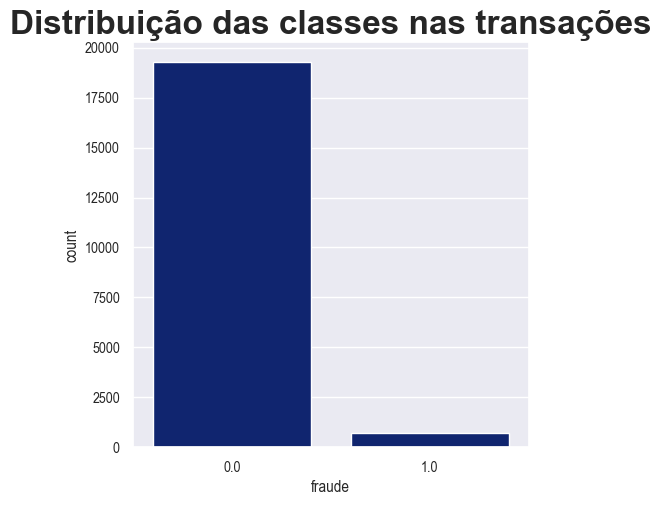

In [26]:

# 2.2 ENTENDENDO A DISTRIBUIÇÃO DAS CLASSES 
plt.figure(figsize=(10,5))
plt.subplot(121)

# 2.2.1 imprimindo a quantidade de cada classe
print(f'Transações sem fraudes: {round(dfn.fraude.value_counts(normalize=True)[0]*100, 2)}%')
print(f'Transações com fraudes: {round(dfn.fraude.value_counts(normalize=True)[1]*100, 2)}%\n')

# 2.2.2 definindo a área de plotagem
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = (18,12)
plt.rcParams['font.size'] = 24
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2

# 2.2.3 plotando o gráfico
sns.countplot(x = 'fraude', data = dfn)

# 2.2.4 definindo título
plt.title('Distribuição das classes nas transações', fontweight='bold', fontsize=24)

# 2.2.5 exibindo o gráfico
plt.show()

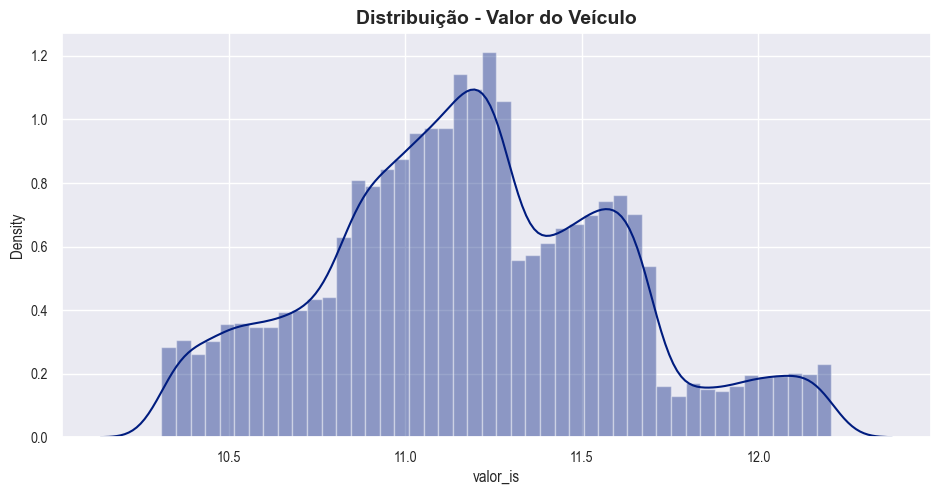

In [27]:
# 2.3 EXPLORANDO VARIÁVEL valor_is
# 2.3.1 definindo a área de plotagem
plt.figure(figsize=(10,5))

# 2.3.2 plotando o gráfico
sns.distplot(dfn.valor_is)

# 2.3.3 definindo título
plt.title("Distribuição - Valor do Veículo", fontsize=14, fontweight='bold')

# 2.3.4 exibindo o gráfico
plt.show()

<Figure size 1000x500 with 0 Axes>

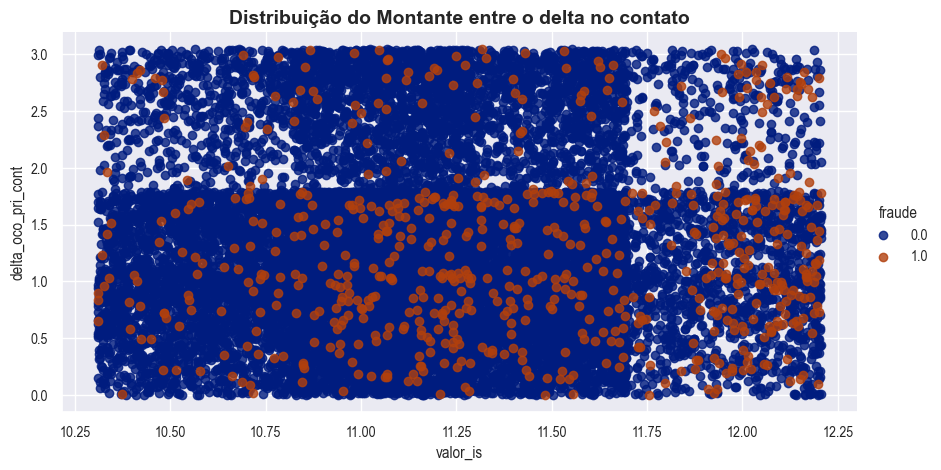

In [28]:
# 2.4 EXPLORANDO VARIÁVEL delta_oco_pri_cont
# 2.4.1 definindo a área de plotagem
plt.figure(figsize=(10,5))

# 2.4.2 plotando o gráfico
sns.lmplot(y='delta_oco_pri_cont',x='valor_is', data=dfn, fit_reg=False, aspect=1.8, hue='fraude')

# 2.4.3 definindo título
plt.title("Distribuição do Montante entre o delta no contato", fontsize=14, fontweight='bold')

# 2.4.4 exibindo o gráfico
plt.show()

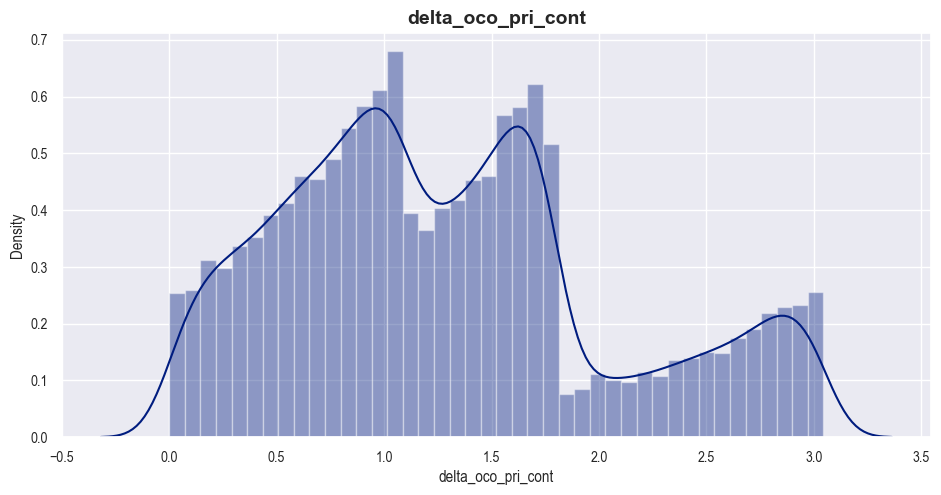

In [29]:
# 2.5 DISTRIBUIÇÃO DE delta_oco_pri_cont
# 2.5.1 definindo a área de plotagem
plt.figure(figsize=(10,5))

# 2.5.2 plotando o gráfico
sns.distplot(dfn.delta_oco_pri_cont)

# 2.5.3 definindo título
plt.title("delta_oco_pri_cont", fontsize=14, fontweight='bold')

# 2.5.4 exibindo o gráfico
plt.show()

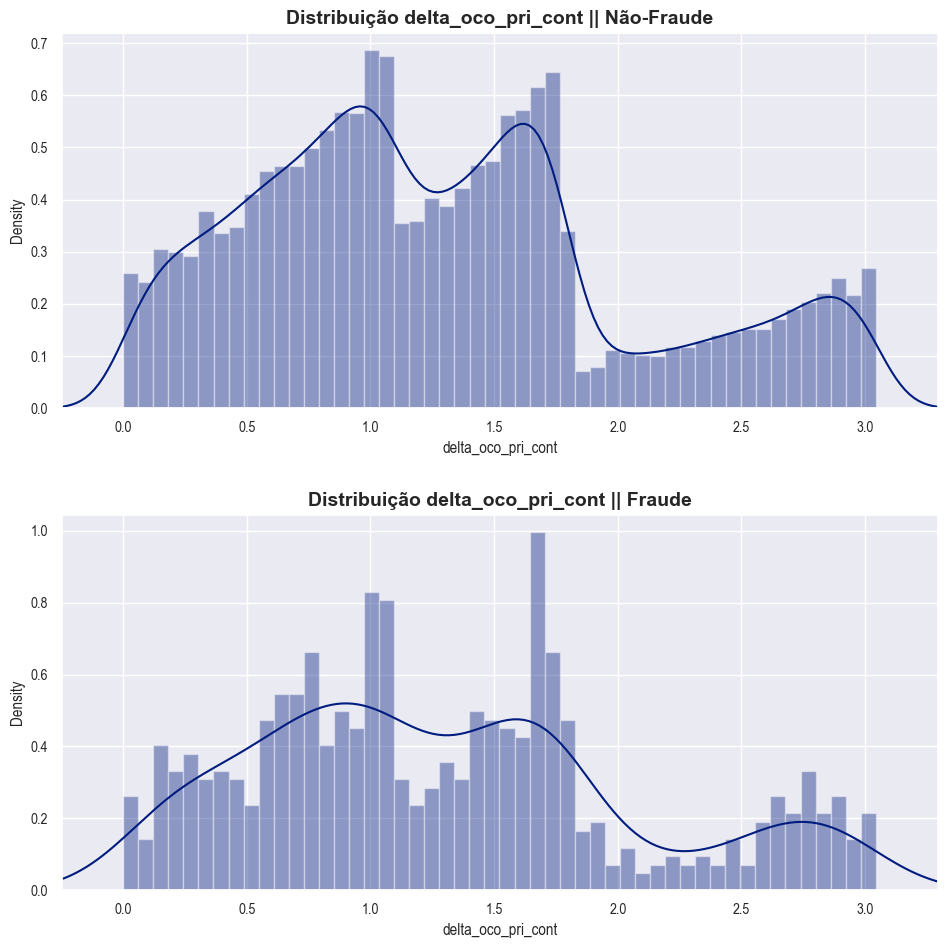

In [30]:
# 2.6 DISTRIBUIÇÃO DE delta_oco_pri_cont NÃO FRAUDE X FRAUDE
# 2.6.1 definindo a área de plotagem
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))

# 2.6.2 plotando o gráfico
sns.distplot(dfn[dfn.fraude==0]['delta_oco_pri_cont'], ax=ax1, bins=50)
sns.distplot(dfn[dfn.fraude==1]['delta_oco_pri_cont'], ax=ax2, bins=50)

# 2.6.3 definindo título
ax1.set_title("Distribuição delta_oco_pri_cont || Não-Fraude", fontsize=14, fontweight='bold')
ax2.set_title("Distribuição delta_oco_pri_cont || Fraude", fontsize=14, fontweight='bold')

# 2.6.4 definindo eixo x
ax2.set_xlim(dfn.delta_oco_pri_cont.min()-0.25, dfn.delta_oco_pri_cont.max()+0.25)
ax1.set_xlim(dfn.delta_oco_pri_cont.min()-0.25, dfn.delta_oco_pri_cont.max()+0.25)

# 2.6.5 exibindo o gráfico
plt.tight_layout()
plt.show()

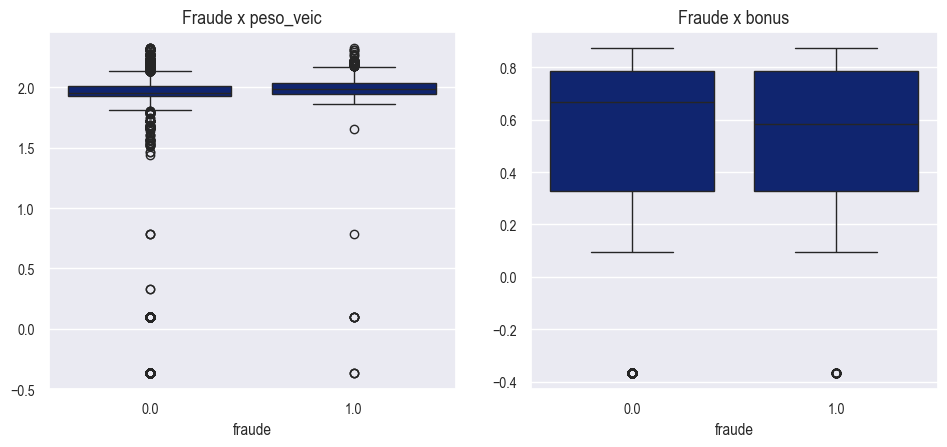

In [31]:
# 2.7 EXPLORANDO AS VARIÁVEIS peso_veic e bonus
plt.figure(figsize=(10,5))
plt.subplot(121)
ax1 = sns.boxplot(x ="fraude",y=np.log(dfn.peso_veic), data=dfn)
ax1.set_title("Fraude x peso_veic", fontsize=14)
ax1.set_xlabel("fraude", fontsize=12)
ax1.set_ylabel("")

plt.subplot(122)
ax1 = sns.boxplot(x ="fraude",y=np.log(dfn.bonus), data=dfn)
ax1.set_title("Fraude x bonus", fontsize=14)
ax1.set_xlabel("fraude", fontsize=12)
ax1.set_ylabel("")

plt.tight_layout()
plt.show()

In [32]:
# 3. MACHINE LEARNING

# 3.1 SEPARANDO OS DADOS PARA TREINO E TESTE
dfn_train, dfn_test = train_test_split(dfn, test_size=0.5, random_state=40, shuffle=True)

# 3.2 VISUALIZANSO AS PROPORÇÕES DA VARIÁVEL ALVO
dfn_train.fraude.value_counts(normalize=True)





fraude
0.0    0.9653
1.0    0.0347
Name: proportion, dtype: float64

In [33]:
# 3.3 VISUALIZANSO AS PROPORÇÕES DA VARIÁVEL ALVO
dfn_test.fraude.value_counts(normalize=True)

fraude
0.0    0.9654
1.0    0.0346
Name: proportion, dtype: float64

In [34]:
# 3.4 DEFININDO A BASELINE
# 3.4.1 dividindo X e y
X = dfn_train.drop('fraude', axis=1)
y = dfn_train.fraude

# 3.4.2 separando os dados mantendo a porcentagem de amostras em cada classe
StratifKfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# 3.4.3 looping para separar os dados em treino e validação
for train_index, val_index in StratifKfold.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

# 3.4.4 checando as proporções da classe 1 na divisão
print(f'Dimensões: {X_train.shape, X_val.shape, y_train.shape, y_val.shape}\n')
print(f"Proporção do df_train para classe=1: {round(len(dfn_train[dfn_train.fraude==1]) / dfn_train.shape[0], 4)}\n")
print(f"Proporção de X_train para classe=1:  {round(len(y_train[y_train==1]) / X_train.shape[0], 4)}")
print(f"Proporção de X_val para classe=1:    {round(len(y_val[y_val==1]) / X_val.shape[0], 4)}")

Dimensões: ((6667, 181), (3333, 181), (6667,), (3333,))

Proporção do df_train para classe=1: 0.0347

Proporção de X_train para classe=1:  0.0348
Proporção de X_val para classe=1:    0.0345


In [35]:
# 3.5 MODELO xgboost
X = dfa.drop(['fraude'],axis=1)
y = df.fraude

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from statistics import mean

model = XGBClassifier(scale_pos_weight=96.53, colsample_bytree=0.5, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.5)

# 3.5.1 define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# 3.5.2 evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

# 3.5.3 summarize performance
print('Mean ROC AUC: %.5f' % mean(scores))

import xgboost as xgb

# 3.5.4 set class weights
class_weights = {0: 9653, 1: 347}  # Class 0: 1, Class 1: 10

# 3.5.5 set "scale_pos_weight" based on class balance
pos_weight = sum(class_weights.values()) / sum(class_weights.keys())

# 3.5.6 train XGBoost model
model = xgb.XGBClassifier(scale_pos_weight=pos_weight, class_weight=class_weights)
model.fit(X_train, y_train)

from sklearn.metrics import accuracy_score, classification_report
y_pred = model.predict(X_test)
y_test = list(y_test)

# 3.5.7 evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# 3.5.8 printing metrics
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)
print('confusion_matrix:\n',confusion_matrix(y_test, y_pred))

Mean ROC AUC: 0.87191
Accuracy: 0.9036363636363637
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.91      0.95      6366
         1.0       0.21      0.65      0.32       234

    accuracy                           0.90      6600
   macro avg       0.60      0.78      0.64      6600
weighted avg       0.96      0.90      0.93      6600

confusion_matrix:
 [[5813  553]
 [  83  151]]


In [36]:
# 3.6 APLICANDO Grid Search
# 3.6.1 definindo listas vazias para receber os resultados da validação cruzada
##Modelo:    xgboost

from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# 3.6.2 define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.5, 0.7],
    'n_estimators': [100, 200, 300]
}

# 3.6.3 initialize XGBoost model
xgb_model = xgb.XGBClassifier()

# 3.6.4 perform Grid Search
grid_search = GridSearchCV(estimator = xgb_model, param_grid = param_grid, cv=3)
grid_search.fit(X_train, y_train)

# 3.6.5 get best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'colsample_bytree': 0.5, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}


<Axes: >

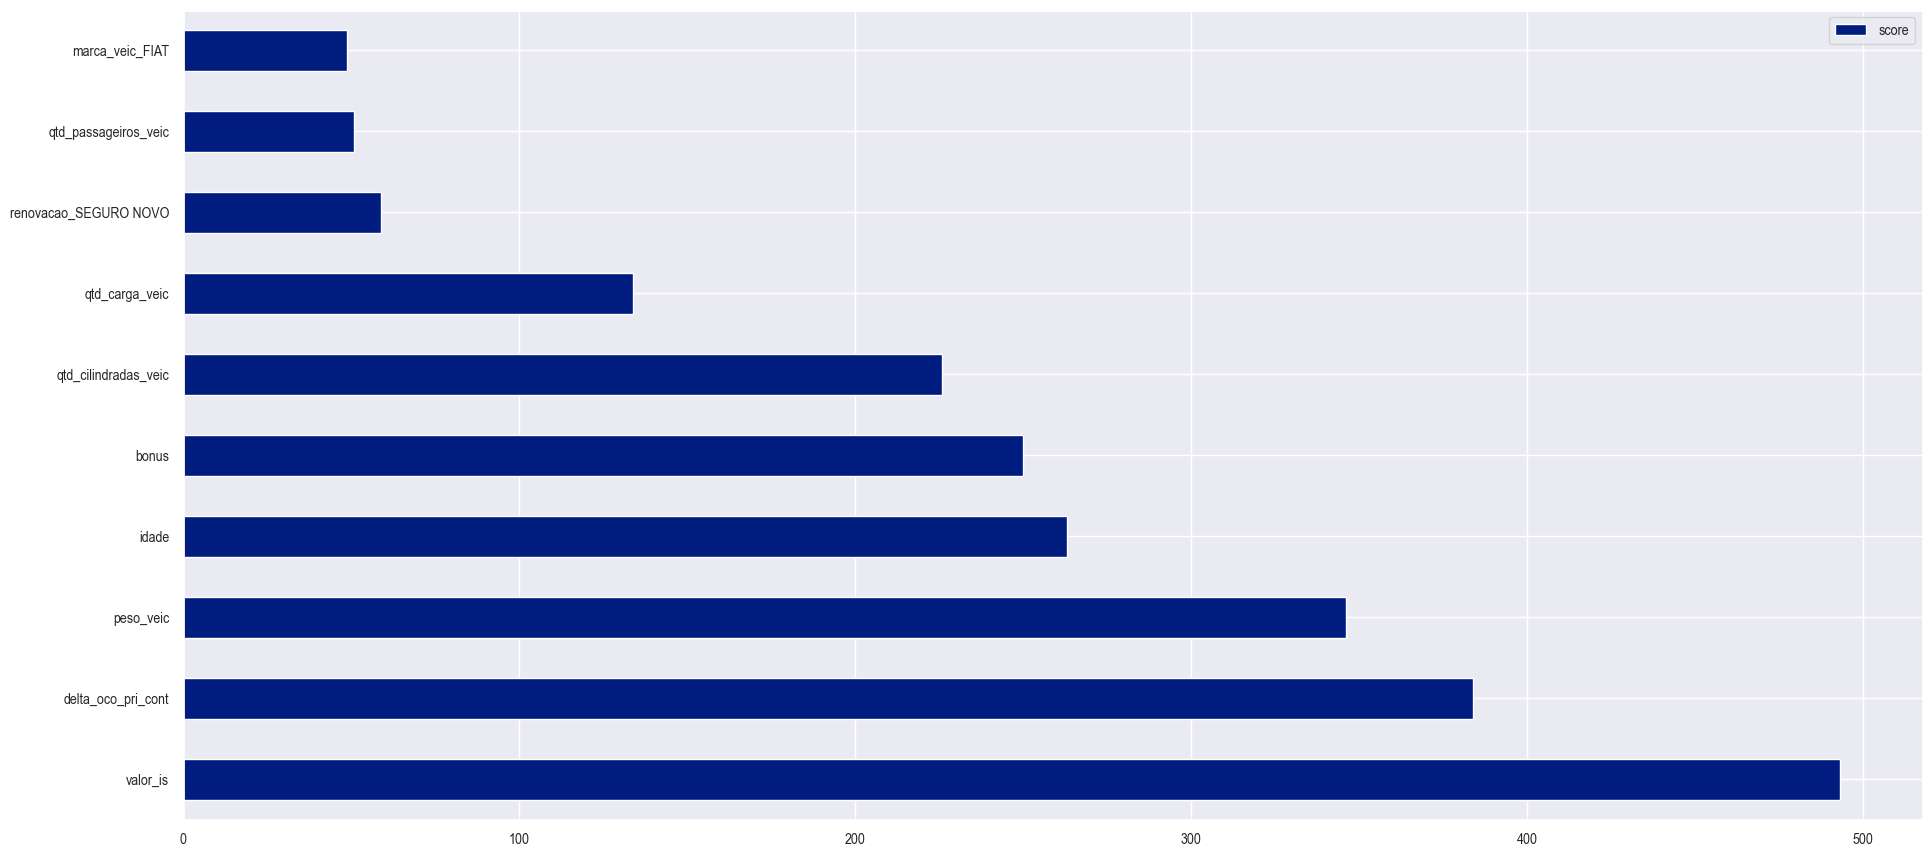

In [37]:
# 3.7 CONHECENDO AS VARIÁVEIS IMPORTANTES
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(10, columns="score").plot(kind='barh', figsize = (20,10))

In [38]:
# 4. CÁLCULO DE SAVING GERADO PELO MODELO

# 4.1 GASTO EM FRAUDE NO PERÍODO

# 4.2 VALOR MÉDIO DOS VEÍCULOS (para fraude = 1)
valor_medio_fraudes = df.loc[df['fraude'] == 1, 'valor_is'].mean()

# 4.3 Nº DE FRAUDES DA BASE
n_fraudes = sum(df.fraude == 1)

# 4.4 VALOR DE RECALL (weighted avg)
recall = 0.90

# 4.5 SAVING DA BASE
saving = valor_medio_fraudes*n_fraudes*recall

print(len(dfn))

print(f"valor_medio_fraudes: {valor_medio_fraudes}")
print(f"n_fraudes: {n_fraudes}")

print(f"Sinistros: {df.loc[df['fraude'] == 1, 'valor_is'].sum()}")
print(f"Fraude no período: {df.loc[df['fraude'] == 1, 'valor_is'].sum()}")
print(f"Fraude média mensal: {(df.loc[df['fraude'] == 1, 'valor_is'].sum())/11}")
print(f"Saving: {saving}")
print(f"Saving Mensal: {saving/11}")

20000
valor_medio_fraudes: 102926.96392496393
n_fraudes: 693
Sinistros: 71328386.0
Fraude no período: 71328386.0
Fraude média mensal: 6484398.7272727275
Saving: 64195547.4
Saving Mensal: 5835958.8545454545
